# Harris Corner Detection
The Harris corner detector is a feature detector based on a 2D structure tensor.

The final equation, after a Taylor expansion and some simplification, is
$$
E(u, v) \approx \begin{bmatrix} u & v\end{bmatrix} M \begin{bmatrix} u \\ v\end{bmatrix},
$$
where 
$$
M = \sum_{x,y} w(x,y) \begin{bmatrix} I_xI_x & I_xI_y\\ I_xI_y & I_yI_y \end{bmatrix}.
$$

The window function $w(x,y)$ is typically a window with a Gaussian kernel.

### General Steps
- Convert image to grayscale
- Calculate Gaussian blur
- Calculate image derivatives
- Loop over pixels, create structure tensor
- Calculate Harris response
- Threshold responses

#### Convert image to grayscale
The `image = np.asarray(Image.open(image_path).convert('L'))` opens and converts an image to grayscale. Why do we convert RGB to grayscale?

Read in checker.jpg. Shape: (360, 566)


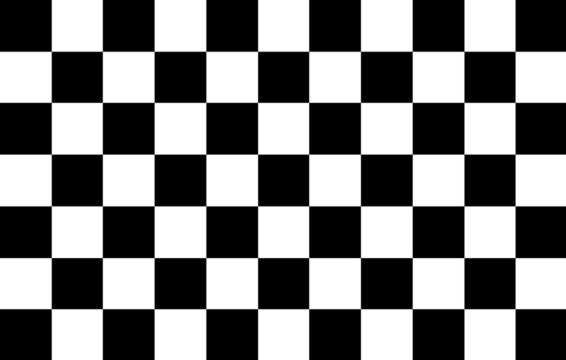

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# image_path = 'rice.png'
image_path = 'checker.jpg'

# Read in image as grayscale and store as an array
image = np.asarray(Image.open(image_path).convert('L'))
print(f'Read in {image_path}. Shape: {image.shape}')
width = image.shape[1]
height = image.shape[0]
Image.fromarray(image)

#### Gaussian blur and image derivatives
What's the purpose of using a Gaussian blur on an image? How does it help features?

The image derivatives can be calculated with sobel filters. Notice that the sobel filters are used after a Gaussian blur. Is there a faster way to convolve the image twice with two different filters?

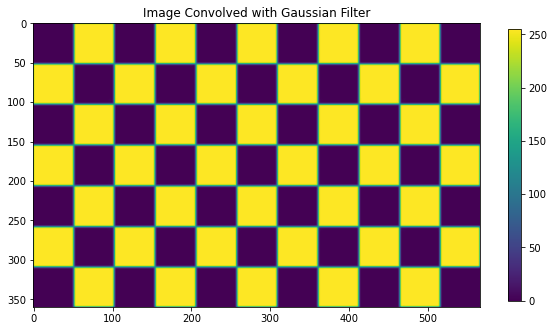

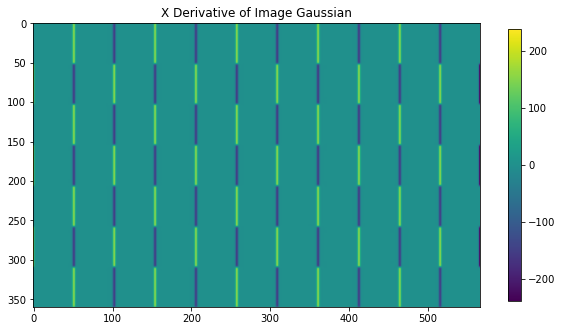

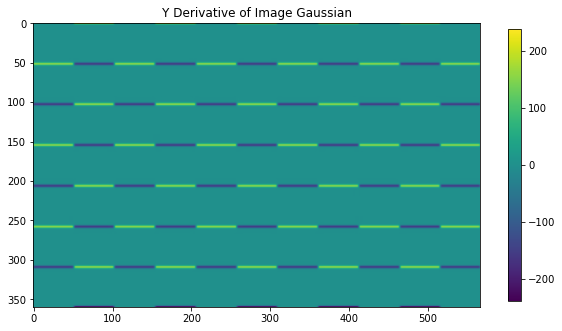

In [2]:
from scipy.signal import convolve2d

gauss = np.array([[1,  4,  7,  4, 1],
                  [4, 16, 26, 16, 4],
                  [7, 26, 41, 26, 7],
                  [4, 16, 26, 16, 4],
                  [1,  4,  7,  4, 1]]) * 1/273

sobel_x = np.array([[ 1,  0, -1]])

sobel_y = np.array([[ 1],
                    [ 0],
                    [-1]])

img_g = convolve2d(image, gauss, mode='same')
plt.figure(figsize=(10,10))
plt.title('Image Convolved with Gaussian Filter')
plt.imshow(img_g)
plt.colorbar(shrink=0.5)

img_g_dx = convolve2d(img_g, sobel_x, mode='same')
plt.figure(figsize=(10,10))
plt.title('X Derivative of Image Gaussian')
plt.imshow(img_g_dx)
plt.colorbar(shrink=0.5)

img_g_dy = convolve2d(img_g, sobel_y, mode='same')
plt.figure(figsize=(10,10))
plt.title('Y Derivative of Image Gaussian')
plt.imshow(img_g_dy)
plt.colorbar(shrink=0.5)

#### Set up structure tensor look-up tables

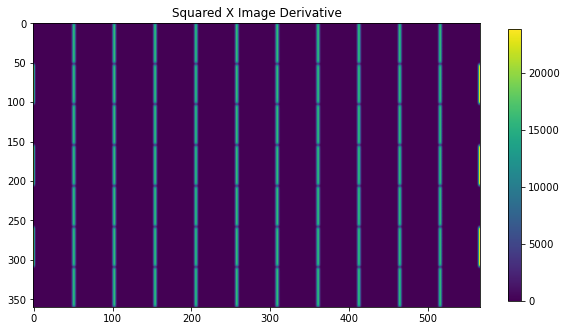

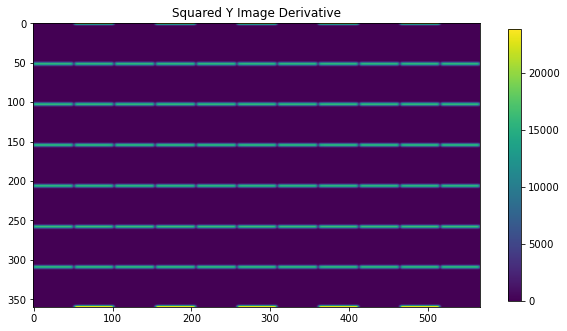

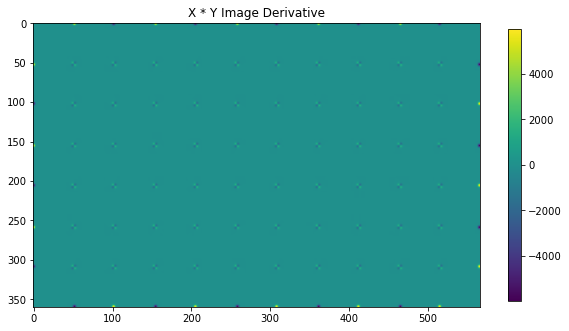

In [3]:
img_dxdx = convolve2d(np.multiply(img_g_dx, img_g_dx), gauss, mode='same')
img_dydy = convolve2d(np.multiply(img_g_dy, img_g_dy), gauss, mode='same')
# Do we need dydx too?
img_dxdy = convolve2d(np.multiply(img_g_dx, img_g_dy), gauss, mode='same')

plt.figure(figsize=(10,10))
plt.imshow(img_dxdx)
plt.title('Squared X Image Derivative')
plt.colorbar(shrink=0.5)

plt.figure(figsize=(10,10))
plt.imshow(img_dydy)
plt.title('Squared Y Image Derivative')
plt.colorbar(shrink=0.5)

plt.figure(figsize=(10,10))
plt.imshow(img_dxdy)
plt.title('X * Y Image Derivative')
plt.colorbar(shrink=0.5)

#### Harris detect function
- Uses a square window
- Ignores image edges
- Computes just the eigenvalues of the structure tensor
- Stores Harris response in a matrix

In [4]:
def HarrisDetect(img_dxdx: np.ndarray, img_dydy: np.ndarray, 
                 img_dxdy: np.ndarray, win_size: int = 1, 
                 step: int = 1, k: float = 0.04) -> np.ndarray:

    rows, cols = img_dxdx.shape
    radius = int((win_size - 1) / 2)

    R_response = np.zeros(img_dxdx.shape)

    for row in np.arange(0 + radius, rows - radius, step):
        for col in np.arange(0 + radius, cols - radius, step):
            window_rows = np.arange(row - radius, row + radius + 1)
            window_cols = np.arange(col - radius, col + radius + 1)

            # Mesh grid of indices
            window_idx = np.ix_(window_rows, window_cols)

            Ixx = np.sum(img_dxdx[window_idx].flatten())
            Iyy = np.sum(img_dydy[window_idx].flatten())
            Ixy = np.sum(img_dxdy[window_idx].flatten())
            tensor = np.array([[Ixx, Ixy],
                               [Ixy, Iyy]])

            eigenvals = np.linalg.eigvalsh(tensor)
            R_response[row, col] = (eigenvals[0] * eigenvals[1] - 
                                    k * ((eigenvals[0] + eigenvals[1]) ** 2))

    return R_response

Note that the code
```python
window_rows = np.arange(row - radius, row + radius + 1)
window_cols = np.arange(col - radius, col + radius + 1)

# Mesh grid of indices
window_idx = np.ix_(window_rows, window_cols)

Ixx = np.sum(img_dxdx[window_idx].flatten())
Iyy = np.sum(img_dydy[window_idx].flatten())
Ixy = np.sum(img_dxdy[window_idx].flatten())
```
is the same as

```python
Ixx = np.sum(img_dxdx[row-radius:row+radius+1,col-radius:col+radius+1].flatten())
Iyy = np.sum(img_dydy[row-radius:row+radius+1,col-radius:col+radius+1].flatten())
Ixy = np.sum(img_dxdy[row-radius:row+radius+1,col-radius:col+radius+1].flatten())
```

##### What do the eigenvalues of a structure tensor tell us?
First, understand the theorem that if $A$ is an $n \times n$ symmetric matrix, then any two eigenvectors associated with distinct eigenvalues are orthogonal. Structure tensors are symmetric by definition, so as long as the eigenvalues are distinct, then the eigenvectors form a basis.

This basis represents the distribution of the gradient, with the eigenvalues representing the magnitude of the distribution of the gradient. Using this information, then the eigenvalues $\lambda_1, \lambda_2$ can be used to classify a pixel based on its window. When both $\lambda_1$ and $\lambda_2$ are large and approximately equal, then the gradient increases in both direction and forms a corner. When one eigenvalue is much larger than the other, $\lambda_1 \gg \lambda_2$ or $\lambda_2 \gg \lambda_1$, then the intensity predominantly increases in only one direction. Finally, if both $\lambda_1, \lambda_2$ are small, then the area is flat.

This is usually combined into the function
$$
R = \mathrm{det}(M) - k(\mathrm{trace}(M))^2,
$$
so that when $|R|$ is small, the area is flat; when $R < 0$, the area is an edge; and when $R$ is large, the region is a corner.

Using $\lambda_1$ and $\lambda_2$,
$$
R = \lambda_1 \lambda_2 - k (\lambda_1 + \lambda_2)^2.
$$

You are encouraged to create image plots that display the eigenvectors at certain points, so that you may understand what the orientation and magnitude of these eigenvectors communicate. Draw an ellipse around them. What shape do they make when it's a flat region? An edge? A corner?

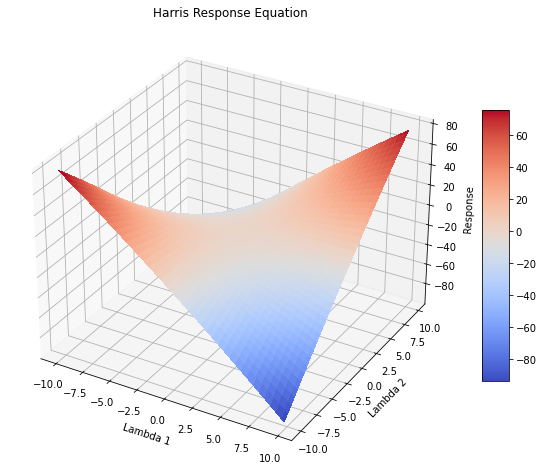

In [5]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

def ShowResponseEquation3D():
    fig, ax = plt.subplots(subplot_kw={"projection" : "3d"})

    X = np.arange(-10, 10, 0.25)
    Y = np.arange(-10, 10, 0.25)
    X, Y = np.meshgrid(X, Y)
    Z = np.multiply(X, Y) - 0.05 * (X + Y) ** 2

    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, 
                           antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.set_title('Harris Response Equation')
    ax.set_xlabel('Lambda 1')
    ax.set_ylabel('Lambda 2')
    ax.set_zlabel('Response')
    plt.show()
    
ShowResponseEquation3D()

In [6]:
# Separate cell for detection, so changing the threshold is faster
response = HarrisDetect(img_dxdx, img_dydy, img_dxdy, 5)

Threshold: 204.0
Amount: 643


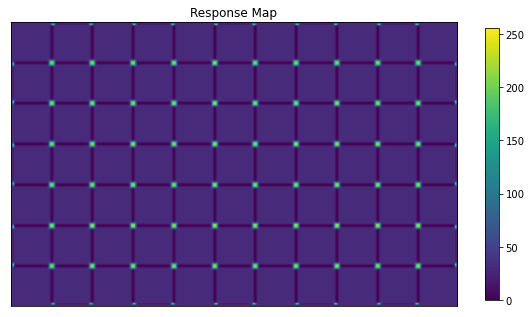

In [7]:
# Rescale response
response = (response - response.min()) * 255 / (response.max() - response.min())

# Show response
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.title('Response Map')
plt.imshow(response)
plt.colorbar(shrink=0.5)

# Threshold based off a percent of the maximum
threshold = 0.8 * response.max()
n_responses = np.sum(response > threshold)

print(f'Threshold: {threshold}\nAmount: {n_responses}')
response_idx = np.asarray((response > threshold).nonzero())

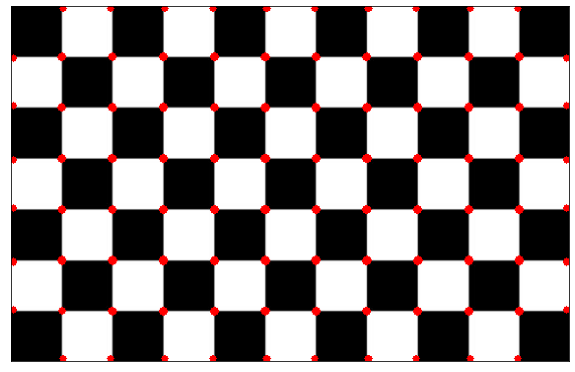

In [8]:
import cv2
from matplotlib import pyplot as plt

image_features = cv2.imread(image_path)
for i in np.arange(response_idx.shape[1]):
    image_features = cv2.circle(image_features, 
        (response_idx[1,i], response_idx[0,i]), 
        radius=3, color=(255,0,0), thickness=-1)

# Display image
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(image_features)